# Wavecrest propagation speed of MinDE patterns

*Jacob Kerssemakers, Sabrina Meindlhumer, Cees Dekker lab, 2022*

The flowing, semi-periodic patterns of MinDE pose some challenges to quantification. Here, we illustrate a systematic approach to determine wavecrest propagation velocities $\vec{v}$ = ($v_x$, $v_y$) for individual wave crest points.<br>
Our approach includes the identification of wave crests (using optical flow image analysis tools) and frame-wise comparison of crest positions to determine their local propagation speed. Unlike global analysis (compare our illustration for extraction of global parameters using autocorrelation methods), this approach has the potential to directly yield large distributions of parameters, associated with their ($x$, $y$) coordinates within the field-of-view.<br>
<br>
**READ-ME:**<br>
Cells in this notebook need to be executed sequentially. Upon starting to explore this notebook, click the ▷▷ symbol above (*Restart the kernel, then re-run the whole notebook*) and hit "Restart" to ensure all required packages are loaded. After that, the notebook will take a few moments to set up, and figures/plots will re-appear one by one.<br>
At distinct positions in the notebook, the user is invited to change numeric input. After doing so, the notebook needs to be executed anew at least from this point on for changes to be applied.<br>
The notebook can be re-run from any given point onwards by clicking *Run* in the menu-bar above, and selecting *Run Selected Cell and All Below*. Alternatively, the ▷▷ symbol can be used again, which will re-run the notebook from the start. This will take a moment longer, but will have the same effect.

## Setup
Import of standard modules, the used flow field analysis method (Horn-Schunck) and assisting custom-made modules. Needs to be executed at least once to ensure correct functionality (see instructions above).

In [1]:
from pathlib import Path
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from cv2 import filter2D

from pyoptflow import HornSchunck
from min_analysis_tools.get_auto_halfspan import get_auto_halfspan
from min_analysis_tools import get_data, min_de_patterns_crests, peak_profile
from min_analysis_tools.local_velocity_analysis import local_velocity_analysis

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

## Select example
Choose one out of four possible provided example files in the list below:<br>
(1) Simulated spiral<br>
(2) Min spiral (example data)<br>
(3) Min southeast-directed traveling waves (example data)<br>
(4) Min large stitched pattern (example data)<br>
(5) Min horizontally stitched pattern (example data)<br>
<br>
Choose the example by setting the variable *selection* in the code-box below. The notebook needs to be re-run (at least from the point onwards) for changes to be applied.

In [2]:
selection = 1 # set to 1 ... 5

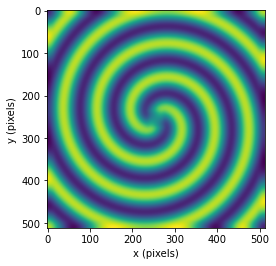

Current selection: 1


In [3]:
if selection not in np.arange(1, 6):
    print("Invalid selection. Set to selection 1 (Simulated spiral).")
    selection = 1
    MinDE_st_original = get_data.generate_pattern(
        lambda_t=10, lambda_x=1, size=512, N_frames=50, demo=False
    )
    crest_index_auto = 300
    zm_lo = 50
    zm_hi = 75
elif selection == 1:  # "Simulated spiral"
    MinDE_st_original = get_data.generate_pattern(
        lambda_t=10, lambda_x=1, size=512, N_frames=50, demo=False
    )
    crest_index_auto = 300
    zm_lo = 50
    zm_hi = 75
elif selection > 1:
    if selection == 2:  # "Min spiral (example data)"
        stack_path = Path().cwd() / "example_data" / "real_spiral.tif"
        crest_index_auto = 150
        zm_lo = 75
        zm_hi = 100
    if selection == 3:  # "Min southeast-directed traveling waves (example data)"
        stack_path = Path().cwd() / "example_data" / "real_southeast.tif"
        crest_index_auto = 150
        zm_lo = 75
        zm_hi = 100
    if selection == 4:  # "Min large stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "real_square_stitch.tif"
        crest_index_auto = 300
        zm_lo = 75
        zm_hi = 100
    if selection == 5:  # "Min horizontally stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "real_horizontal_stitch.tif"
        crest_index_auto = 300
        zm_lo = 65
        zm_hi = 90
    MinDE_st_original = io.imread(stack_path)
nt, ny, nx = np.shape(MinDE_st_original)
auto_halfspan = get_auto_halfspan(
    MinDE_st_original, frames_to_analyse=10, verbose=False
)

fig, ax = plt.subplots()
ax.imshow(MinDE_st_original[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

print(f"Current selection: {selection}")

Note that depending on what environment we use, the orientation of $x$- or $y$-components does not always match what you see by eye when opening the image stack with an image viewer, such as Fiji. When relying on the indexing used by NumPy and representation by Matplotlib, we can ensure that the final vector direction matches the apparent directionality by performing some simple transformations on the stack before starting.

In [4]:
MinDE_st = min_de_patterns_crests.adjust_stack_orientation(MinDE_st_original)

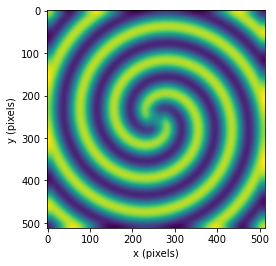

In [5]:
fig, ax = plt.subplots()
ax.imshow(MinDE_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

An important parameter to define is *halfspan*, the meaning of which will be explained further below. As a rule of thumb, *halfspan* should be set to approximately half the global wavelength. This can be determined from global analysis or estimated from visual inspection of the pattern.<br>
For our demo, we suggest default values for *halfspan*, determined via spatial autocorrelation analysis in the code-box below the example selection. To try other values for *halfspan*, replace "auto_halfspan" by a numeric value (length in pixel). Choosing a value that strongly deviates from the recommended one can lead to erroneous results.<br>
Another parameter is *sampling_density*, will later on define the distance between sampling points when comparing crest point position between frames.<br>
<br>
These parameters can be set in the code-box below. The notebook needs to be re-run (at least from this point on) for changes to apply.

In [6]:
halfspan = auto_halfspan  # default: auto_halfspan
sampling_density = 1  # default: 1

In [7]:
print(f"Current halfspan: {halfspan} pixels")
print(f"Current sampling_density: {sampling_density} pixels")

Current halfspan: 47 pixels
Current sampling_density: 1 pixels


In the following, we work through the given image stack by performing optical flow analysis on pairs of sequential images and using this information to identify wave crests.

## Flow field analysis
We build two smoothed image stacks, first one with a finer smoothing kernel, then one with a rather large kernel. The strongly-smoothed stack (*_smz_flow*) is used only for flow analysis (Horn-Schunck), the lightly-smoothed stack (*_smz*) will later on be used for peak detection.

In [8]:
kernel_size_general = 20  # for general (light) smoothing
kernel_size_flow = 50  # stronger smoothing for optical flow analysis

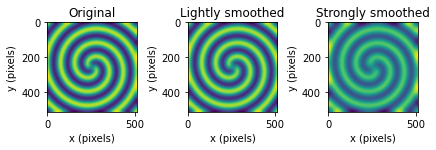

In [9]:
# build kernel for first smoothing step (for processing)
general_kernel = np.ones((kernel_size_general, kernel_size_general), np.float32) / (kernel_size_general ** 2)

# build kernel for obtaining flow pattern
flow_kernel = np.ones((kernel_size_flow, kernel_size_flow), np.float32) / (kernel_size_flow ** 2)

# create lightly and strongly smoothed images
im0_raw = MinDE_st[0, :, :]
im1_raw = MinDE_st[1, :, :]
im0_smz = filter2D(im0_raw, -1, general_kernel)
im1_smz = filter2D(im1_raw, -1, general_kernel)
im0_smz_flow = filter2D(im0_smz, -1, flow_kernel)
im1_smz_flow = filter2D(im1_smz, -1, flow_kernel)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im0_raw)
ax1.set_title("Original")
ax1.set_xlabel("x (pixels)")
ax1.set_ylabel("y (pixels)")
ax2.imshow(im0_smz)
ax2.set_title("Lightly smoothed")
ax2.set_xlabel("x (pixels)")
ax2.set_ylabel("y (pixels)")
ax3.imshow(im0_smz_flow)
ax3.set_title("Strongly smoothed")
ax3.set_xlabel("x (pixels)")
ax3.set_ylabel("y (pixels)")
fig.tight_layout()
plt.show()

For each sequential pair of images in our stack, we first perform flow analysis using Horn-Schunck algorithm, which gives us an estimate of the local mass flow of fluorescent intensity between subsequent image frames<br>
We obtain this information in the form of flow field vector maps describing the local flow components in $x$- and $y$-direction. Note that this is still local flow and not the actual wave propagation. In the map below, the magnitude of each position's corresponding flow vector is shown as image brightness.

In [10]:
flow_x, flow_y = HornSchunck(im0_smz_flow, im1_smz_flow, alpha=100, Niter=100)

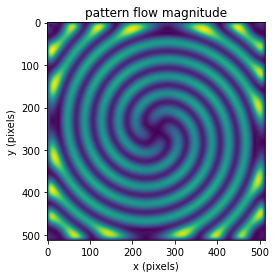

In [11]:
# Show the optical flow magnitude
flow_mag = np.hypot(flow_x, flow_y)
fig, ax = plt.subplots()
ax.imshow(flow_mag)
ax.set_title("pattern flow magnitude")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

## Crest detection

Next, we can use this optical flow analysis results to identify wavecrests. We do this by starting from a given pixel position, using the corresponding vector obtained from optical flow analysis and comparing the pixel's intensity to the one at a position located a short distance along the direction of the flow vector.<br>
That allows us to divide the image in areas where fluorescent intensity is decreasing in the direction of flow (corresponding to the "front" of a wave) or increasing (its "wake"). This binary division can be represented as a wavesign-image, representing the front regions as bright and wake regions as dark areas.

In [12]:
wavesign_im = min_de_patterns_crests.get_rise_or_fall(flow_x, flow_y, im0_smz)

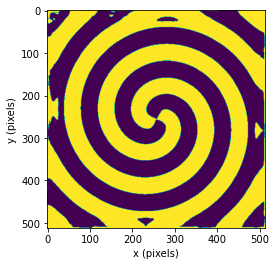

In [13]:
fig, ax = plt.subplots()
ax.imshow(wavesign_im)
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

Using this image, we obtain the crests, defined as the points that lie between front or wake areas *and* where the intensity is above average (since otherwise, we would also get the "valleys"). Each crest point comes with ($x$, $y$) coordinates and a unit vector ($w_x$, $w_y$) perpendicular to the local crest line, in the direction of wave propagation.

In [14]:
(
    crests_x,
    crests_y,
    forward_wavevector_x,  # w_x
    forward_wavevector_y,  # w_y
) = min_de_patterns_crests.get_crests(wavesign_im, im0_smz, halfspan / 2)

In the representation below, the identified wave crests are shown in red, and their direction of propagation is indicated in blue. Crest points close the edges of the frame are discarded to avoid edge-effects.

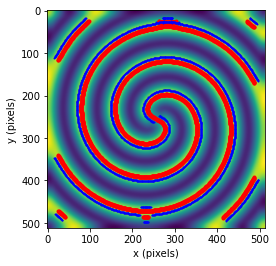

In [15]:
fig, ax = plt.subplots()
span = 10
cx2 = crests_x + span * forward_wavevector_x
cy2 = crests_y + span * forward_wavevector_y
ax.imshow(im0_raw)
ax.plot(crests_x, crests_y, "ro", markersize=3)
ax.plot(cx2, cy2, "bo", markersize=1)
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

## Velocity mapping

We can use the wavevectors at the identified crestpositions to estimate the local propagation of the pattern. For illustration, we plot a corner of the pattern. Again, the detected crest point are shown in red, an indication of local propagation direction in blue. Note that the magnitude of the wavevectors is still normalized here. Crest points that are too close to the edge of the image to be of use for later analysis are discarded.

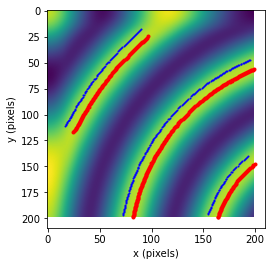

In [16]:
fig, ax = plt.subplots()
zm = 200
Le = len(crests_x)
span = 10
cx1 = crests_x
cy1 = crests_y
cx2 = cx1 + span * forward_wavevector_x
cy2 = cy1 + span * forward_wavevector_y
zm_ix = np.argwhere((cx1 < zm) & (cy1 < zm))
ax.imshow(im0_raw[0 : zm - 1, 0 : zm - 1])
ax.plot(cx1[zm_ix], cy1[zm_ix], "ro", markersize=3)
ax.plot(cx2[zm_ix], cy2[zm_ix], "bo", markersize=1)
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

For each crest point and its accompanying wavevector, we can now obtain a cross-section profile by two-dimensional interpolation. For efficiency, this is done as a grid-style 2D interpolation for all the crest points together.<br>
Left panel: For clarity, we show a zoomed-in section of the pattern and the overlaying crests (red) and cross-section samplings (black). Right panel: The corresponding sampling map. 

In [17]:
(profile_map1, xxgrid, yygrid,) = min_de_patterns_crests.sample_crests(
    im0_smz,
    crests_x,
    crests_y,
    forward_wavevector_x,
    forward_wavevector_y,
    halfspan,
    sampling_density,
)

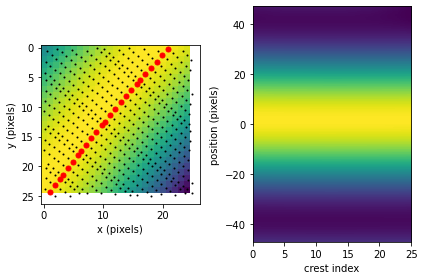

In [18]:
# Show a zoom-in of the result, specified by the variables zm_lo and zm_hi
# zm_lo and zm_hi are defined in the code-box below the selection above

rr, cc = np.shape(im0_raw)
zm_ix1 = np.argwhere(
    (crests_x > zm_lo) & (crests_y > zm_lo) & (crests_x < zm_hi) & (crests_y < zm_hi)
)
zm_ix2 = np.argwhere(
    (xxgrid.ravel() > zm_lo)
    & (yygrid.ravel() > zm_lo)
    & (xxgrid.ravel() < zm_hi)
    & (yygrid.ravel() < zm_hi)
)
fig, (ax_1, ax_2) = plt.subplots(1, 2)

ax_1.imshow(im0_raw[zm_lo:zm_hi, zm_lo:zm_hi])
ax_1.plot(
    xxgrid.ravel()[zm_ix2] - zm_lo,
    yygrid.ravel()[zm_ix2] - zm_lo,
    "ko",
    markersize=1,
)
ax_1.plot(
    crests_x[zm_ix1] - zm_lo,
    crests_y[zm_ix1] - zm_lo,
    "ro",
    markersize=5,
)
ax_1.set_xlabel("x (pixels)")
ax_1.set_ylabel("y (pixels)")

ax_2.imshow(
    profile_map1.T[:, zm_ix1],
    aspect="auto",
    origin="lower",
    extent=[0, crests_x[zm_ix1].size, -halfspan, halfspan],
)
ax_2.set_xlabel("crest index")
ax_2.set_ylabel("position (pixels)")

fig.tight_layout()
plt.show()

The same sampling grid is now used for the next image frame. As can be seen in the second sampling map, the (upwards) shift of all profile maxima reflects the motion of the crests from one frame to the next.<br>
Note that the parameter *halfspan* defines the distance (plus/minus) starting from the crestposition of the first frame, within which intensities are sampled (at density *sampling_density*).<br>
If there is no shifted intensity profile visible in the sampling map below, it could be that a higher value for *halfspan* has to be chosen.

In [19]:
(profile_map2, xxgrid, yygrid,) = min_de_patterns_crests.sample_crests(
    im1_smz,
    crests_x,
    crests_y,
    forward_wavevector_x,
    forward_wavevector_y,
    halfspan,
    sampling_density,
)

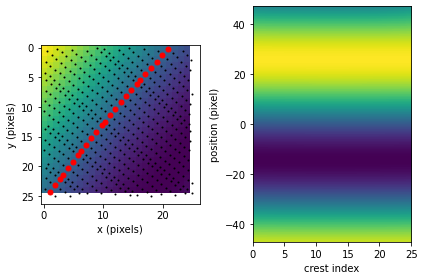

In [20]:
# Show a zoom-in of the result, specified by the variables zm_lo and zm_hi
# zm_lo and zm_hi are defined in the code-box below the selection above

rr, cc = np.shape(im1_raw)
zm_ix1 = np.argwhere(
    (crests_x > zm_lo) & (crests_y > zm_lo) & (crests_x < zm_hi) & (crests_y < zm_hi)
)
zm_ix2 = np.argwhere(
    (xxgrid.ravel() > zm_lo)
    & (yygrid.ravel() > zm_lo)
    & (xxgrid.ravel() < zm_hi)
    & (yygrid.ravel() < zm_hi)
)
fig, (ax_1, ax_2) = plt.subplots(1, 2)

ax_1.imshow(im1_raw[zm_lo:zm_hi, zm_lo:zm_hi])
ax_1.plot(
    xxgrid.ravel()[zm_ix2] - zm_lo,
    yygrid.ravel()[zm_ix2] - zm_lo,
    "ko",
    markersize=1,
)
ax_1.plot(
    crests_x[zm_ix1] - zm_lo,
    crests_y[zm_ix1] - zm_lo,
    "ro",
    markersize=5,
)
ax_1.set_xlabel("x (pixels)")
ax_1.set_ylabel("y (pixels)")

ax_2.imshow(
    profile_map2.T[:, zm_ix1],
    aspect="auto",
    origin="lower",
    extent=[0, crests_x[zm_ix1].size, -halfspan, halfspan],
)
ax_2.set_xlabel("crest index")
ax_2.set_ylabel("position (pixel)")

fig.tight_layout()
plt.show()

## Velocity tracking
The two maps offer two profiles per crest position, one for the current frame (red) and one for the next (blue). For each profile, a sub-unit maximum position is determined by a 3-point parabolic fit around the maximum (black dots).  Since the cross-section was taken perpendicular to the wavecrest, the shift between the two maxima reflect the shift of the crest peak position perpendicular to the local wave orientation. Thus, this shift equals a crest velocity in pixels per frame.<br>
The parameter *look_ahead* = 1 defines that we are looking for a peak in front of the current one, that is, in propagation direction (as determined from optical flow analysis). In other applications of the local analysis pipeline (like DE distance detection, when looking for the position of a MinE wave running behind a MinD wave), it can make sense to look towards the other direction.

In [21]:
velocities = min_de_patterns_crests.compare_crestmaps(
    profile_map1, profile_map2, sampling_density, look_ahead=1
)

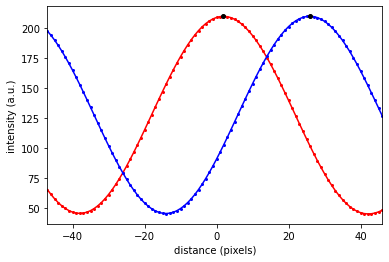

In [22]:
crest_index = crest_index_auto  # crest index for viewing, can be changed here
# by default take pretty one for demo, defined in code-box below selection-widget

# identify peak positions
prf1 = profile_map1[crest_index, :]
prf2 = profile_map2[crest_index, :]
ix1 = peak_profile.get_maxima(prf1, 1)
ix2 = peak_profile.get_maxima(prf2, 1)
x1, y1 = peak_profile.sub_unit_pos(prf1, ix1)
x2, y2 = peak_profile.sub_unit_pos(prf2, ix2)

# shift axis to have first peak close to center and plot
x_axis_shift = np.arange(-halfspan, halfspan)
fig, ax = plt.subplots()
ax.plot(x_axis_shift, prf1, "ro-", markersize=2)
ax.plot(x_axis_shift, prf2, "bo-", markersize=2)
ax.plot(x1 - halfspan, y1, "ko", markersize=4)
ax.plot(x2 - halfspan, y2, "ko", markersize=4)
ax.set_xlabel("distance (pixels)")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([-halfspan, halfspan - 1])
plt.show()

The translocation distance $d$ from peak to peak divided the time $\Delta t$ that passed between the acquisition on sequential frames then yields the velocity magnitude: $v = \frac{d}{\Delta t}$<br>
<br>
Combined with the direction of the normalized flow vectors ($w_x$, $w_y$), this yields a vector $\vec{v}$ for each individual crest position ($x$, $y$).

## Velocity distribution
The analysis routine presented so far can be performed for all pairs of frames within a given image stack. Collecting these results yields a distribution of velocity vectors, which can be represented in different ways, depending on what information (magnitude, directionality) is of interest.

Analysing 5 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
Working frame 3 to 4
Median velocity magnitude: 23.91 pixels/frame


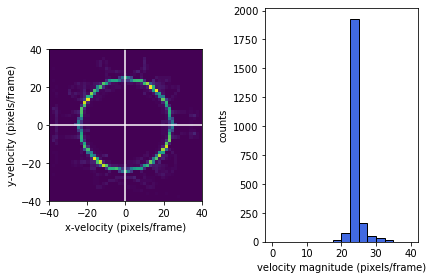

In [23]:
(
    fig,
    ax_wheel,
    ax_sum,
    velocities,  # velocity magnitude
    forward_wavevector_x,  # unit vector w_x
    forward_wavevector_y,  # unit vector w_y
    all_wheels,  # data generated for velocity wheel (2D histogram)
) = local_velocity_analysis(
    MinDE_st_original,
    frames_to_analyse=5,  # use first ... frames
    halfspan=halfspan,
    sampling_density=sampling_density,
    edge=40,  # width of velocity wheel (2D histogram) and max of magnitude histogram
    bins_wheel=50,  # number of bins (horizontal/vertical) for velocity wheel (2D histogram)
    binwidth_sum=2.5,  # binwidth for velocity mangitude histogram
    kernel_size_general=kernel_size_general,  # kernel for first smoothing step
    kernel_size_flow=kernel_size_flow,  # kernel for additional smoothing step
    look_ahead=1,  # 1 -> look in propagation direction, -1 -> against it
    demo=True,  # True -> return figure handles
)
plt.show()